In [1]:
# %matplotlib inline
from pathlib import Path
import pandas as pd
import ctd


path = Path('..', 'tests', 'data')
fname = path.joinpath('CTD-spiked-unfiltered.cnv.bz2')

cast = ctd.from_cnv(fname)
down, up = cast.split()

down.head()

,scan,timeS,t090C,t190C,c0S/m,c1S/m,sbeox0V,par,spar,ph,...,longitude,pumps,pla,sbeox0PS,sbeox0Mm/Kg,dz/dtM,accM,flSP,xmiss,flag
Pressure [dbar],,,,,,,,,,,,,,,,,,,,,
6.433,1.0,0.000,26.9647,26.9314,5.821803,5.800920,2.1099,1.000000e-12,0.0000,8.575,...,-37.22588,False,26.970,69.61016,137.397,0.000,0.00,0.16484,99.2996,False
6.448,2.0,0.042,26.9644,26.9307,5.821615,5.800819,2.1148,1.000000e-12,1.9601,8.580,...,-37.22588,False,26.969,69.82216,137.817,0.351,8.43,0.16484,99.3260,False
6.433,3.0,0.083,26.9642,26.9301,5.821421,5.800727,2.1209,1.000000e-12,0.0000,8.575,...,-37.22588,False,26.969,70.08688,138.341,-0.351,-16.87,0.16606,99.3260,False
6.448,4.0,0.125,26.9639,26.9296,5.821264,5.800727,2.1270,1.000000e-12,0.0000,8.575,...,-37.22588,False,26.969,70.35184,138.865,0.351,16.86,0.16606,99.3260,False
6.433,5.0,0.167,26.9640,26.9291,5.821219,5.800634,2.1331,1.000000e-12,0.0000,8.575,...,-37.22588,False,26.969,70.61657,139.388,-0.351,-16.86,0.16606,99.3525,False


### Plotting on the same axis

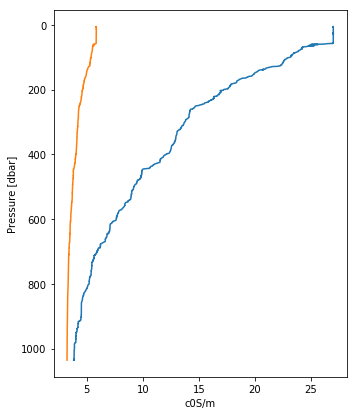

In [2]:
down['t090C'].plot_cast()
down['c0S/m'].plot_cast();

[20870, 20930, 557.5, 559]

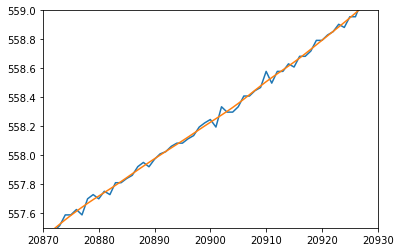

In [3]:
import matplotlib.pyplot as plt


plt.plot(down.index, label='unfiltered')
plt.plot(down.lp_filter().index, label='filtered')
plt.axis([20870, 20930, 557.5, 559])

### Plotting with secondary_y

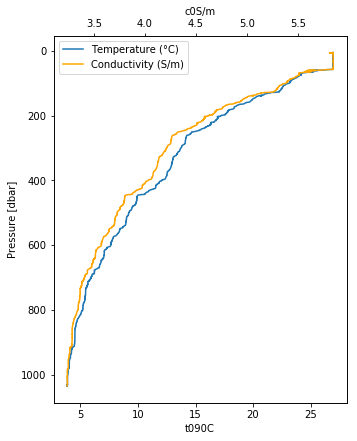

In [4]:
ax0 = down['t090C'].plot_cast(label='Temperature (°C)')
ax1 = down['c0S/m'].plot_cast(
    ax=ax0,
    label='Conductivity (S/m)',
    color='orange',
    secondary_y=True,
)


lines = ax0.get_lines() + ax1.get_lines()
leg = {
    line: line.get_label() for line in lines
}
ax0.legend(leg.keys(), leg.values());

### Metadata

In [5]:
metadata = cast._metadata

metadata.keys()

dict_keys(['header', 'config', 'names', 'skiprows', 'time', 'lon', 'lat', 'name'])

In [6]:
print(metadata['header'])

* Sea-Bird SBE 9 Data File:
* FileName = Z:\CTD_1.hex
* Software Version Seasave V 7.21h
* Temperature SN = 2317
* Conductivity SN = 4010
* Number of Bytes Per Scan = 48
* Number of Voltage Words = 5
* Number of Scans Averaged by the Deck Unit = 1
* Append System Time to Every Scan
* System UpLoad Time = Apr 01 2011 07:26:31
* NMEA Latitude = 17 58.71 S
* NMEA Longitude = 037 13.52 W
* NMEA UTC (Time) = Apr 01 2011  07:26:31
* Store Lat/Lon Data = Append to Every Scan
** Ship: RV Meteor
** Station: 1
** Operator: Ed
* System UTC = Apr 01 2011 07:26:31
*END*


In [7]:
lon, lat = metadata['lon'], metadata['lat']
lon, lat

(-37.22533333333333, -17.9785)

### CTD post-processing

In [8]:
down = down[['t090C', 'c0S/m']]

proc = down.remove_above_water()\
           .despike(n1=2, n2=20, block=100)\
           .lp_filter()\
           .press_check()\
           .interpolate() \
           .bindata(delta=1)\
           .smooth(window_len=21, window='hanning')

proc.head()

,t090C,c0S/m
6.0,26.969753,5.843281
7.0,26.971116,5.843731
8.0,26.972431,5.844163
9.0,26.973650,5.844561
10.0,26.974735,5.844910


## CTD derive

In [9]:
import gsw


p = proc.index

SP = gsw.SP_from_C(proc['c0S/m'] * 10.0, proc['t090C'], p)
SA = gsw.SA_from_SP(SP, p, lon, lat)
SR = gsw.SR_from_SP(SP)

CT = gsw.CT_from_t(SA, proc['t090C'].values, p)
z = -gsw.z_from_p(p, lat)
sigma0_CT = gsw.sigma0(SA, CT)

proc = proc.assign(SP=SP)\
           .assign(SA=SA)\
           .assign(SR=SR)\
           .assign(CT=CT)\
           .assign(z=z)\
           .assign(sigma0_CT=sigma0_CT)

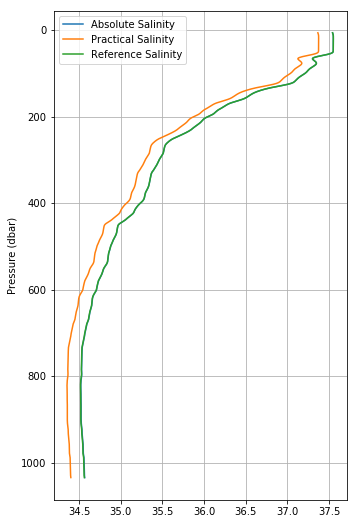

In [10]:
labels = [
    'Absolute Salinity',
    'Practical Salinity',
    'Reference Salinity',
]

ax = proc[['SA', 'SP', 'SR']].plot_cast(
    figsize=(5.25, 9),
    label=labels,
)
ax.set_ylabel('Pressure (dbar)')
ax.grid(True)
ax.legend();

In [11]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

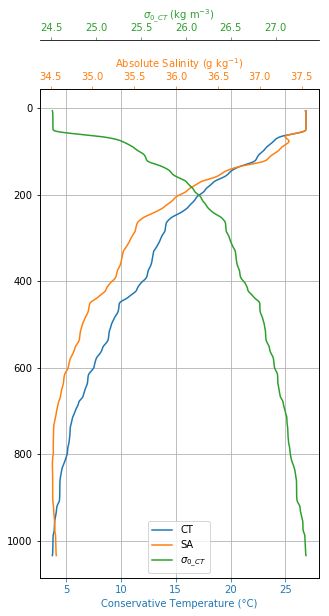

In [12]:
fig, ax0 = plt.subplots(figsize=(5, 9))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

ax0.invert_yaxis()
ax1 = ax0.twiny()
ax2 = ax0.twiny()

l0, = ax0.plot(proc['CT'], proc.index, color=colors[0], label='CT')
ax0.set_xlabel('Conservative Temperature (°C)')

l1, = ax1.plot(proc['SA'], proc.index, color=colors[1], label='SA')
ax1.set_xlabel('Absolute Salinity (g kg$^{-1}$)')

l2, = ax2.plot(proc['sigma0_CT'], proc.index, color=colors[2], label=r'$\sigma_{0\_CT}$')
ax2.set_xlabel(r'$\sigma_{0\_CT}$ (kg m$^{-3}$)')

make_patch_spines_invisible(ax2)
ax2.spines['top'].set_position(('axes', 1.1))
ax2.spines['top'].set_visible(True)

ax0.xaxis.label.set_color(l0.get_color())
ax1.xaxis.label.set_color(l1.get_color())
ax2.xaxis.label.set_color(l2.get_color())

ax0.tick_params(axis='x', colors=l0.get_color())
ax1.tick_params(axis='x', colors=l1.get_color())
ax2.tick_params(axis='x', colors=l2.get_color())

lines = ax0.get_lines() + ax1.get_lines() + ax2.get_lines()
leg = {
    line: line.get_label() for line in lines
}

ax0.legend(leg.keys(), leg.values(), loc=8)
ax0.grid(True);